In [29]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(69)

In [30]:
data = pd.read_csv('Data/Customer_Segmentation_Dataset.csv')
data.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

There are only few rows(1%) that have income value as NULL which can be deleted.

In [32]:
#To remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In [33]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], format="%d-%m-%Y")
dates = []

newest_date = data["Dt_Customer"].max().date()
oldest_date = data["Dt_Customer"].min().date()
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",oldest_date)
print("The oldest customer's enrolment date in the records:",newest_date)

The newest customer's enrolment date in therecords: 2012-07-30
The oldest customer's enrolment date in the records: 2014-06-29


In [34]:
#Created a feature "Customer_For"
# Get the most recent date
newest_date = data["Dt_Customer"].max()

data["Customer_For"] = (newest_date - data["Dt_Customer"]).dt.days

In [35]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


**Feature Engineering**

In [36]:
#Age of customer today 
data["Age"] = 2025-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [37]:
data.describe().transpose()

count          mean           std     min      25%  \
Income               2216.0  52247.251354  25173.076661  1730.0  35303.0   
Kidhome              2216.0      0.441787      0.536896     0.0      0.0   
Teenhome             2216.0      0.505415      0.544181     0.0      0.0   
Recency              2216.0     49.012635     28.948352     0.0     24.0   
Wines                2216.0    305.091606    337.327920     0.0     24.0   
Fruits               2216.0     26.356047     39.793917     0.0      2.0   
Meat                 2216.0    166.995939    224.283273     0.0     16.0   
Fish                 2216.0     37.637635     54.752082     0.0      3.0   
Sweets               2216.0     27.028881     41.072046     0.0      1.0   
Gold                 2216.0     43.965253     51.815414     0.0      9.0   
NumDealsPurchases    2216.0      2.323556      1.923716     0.0      1.0   
NumWebPurchases      2216.0      4.085289      2.740951     0.0      2.0   
NumCatalogPurchases  2216.0      2.671029      2.926734     0.0      0.0   
NumStorePurchases    2216.0      5.800993      3.250785     0.0      3.0   
NumWebVisitsMonth    2216.0      5.319043      2.425359     0.0      3.0   
AcceptedCmp3         2216.0      0.073556      0.261106     0.0      0.0   
AcceptedCmp4         2216.0      0.074007      0.261842     0.0      0.0   
AcceptedCmp5         2216.0      0.073105      0.260367     0.0      0.0   
AcceptedCmp1         2216.0      0.064079      0.244950     0.0      0.0   
AcceptedCmp2         2216.0      0.013538      0.115588     0.0      0.0   
Complain             2216.0      0.009477      0.096907     0.0      0.0   
Response             2216.0      0.150271      0.357417     0.0      0.0   
Customer_For         2216.0    353.521209    202.434667     0.0    180.0   
Age                  2216.0     56.179603     11.985554    29.0     48.0   
Spent                2216.0    607.075361    602.900476     5.0     69.0   
Children             2216.0      0.947202      0.749062     0.0      0.0   
Family_Size          2216.0      2.592509      0.905722     1.0      2.0   
Is_Parent            2216.0      0.714350      0.451825     0.0      0.0   

                         50%       75%       max  
Income               51381.5  68522.00  666666.0  
Kidhome                  0.0      1.00       2.0  
Teenhome                 0.0      1.00       2.0  
Recency                 49.0     74.00      99.0  
Wines                  174.5    505.00    1493.0  
Fruits                   8.0     33.00     199.0  
Meat                    68.0    232.25    1725.0  
Fish                    12.0     50.00     259.0  
Sweets                   8.0     33.00     262.0  
Gold                    24.5     56.00     321.0  
NumDealsPurchases        2.0      3.00      15.0  
NumWebPurchases          4.0      6.00      27.0  
NumCatalogPurchases      2.0      4.00      28.0  
NumStorePurchases        5.0      8.00      13.0  
NumWebVisitsMonth        6.0      7.00      20.0  
AcceptedCmp3             0.0      0.00       1.0  
AcceptedCmp4             0.0      0.00       1.0  
AcceptedCmp5             0.0      0.00       1.0  
AcceptedCmp1             0.0      0.00       1.0  
AcceptedCmp2             0.0      0.00       1.0  
Complain                 0.0      0.00       1.0  
Response                 0.0      0.00       1.0  
Customer_For           355.5    529.00     699.0  
Age                     55.0     66.00     132.0  
Spent                  396.5   1048.00    2525.0  
Children                 1.0      1.00       3.0  
Family_Size              3.0      3.00       5.0  
Is_Parent                1.0      1.00       1.0

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

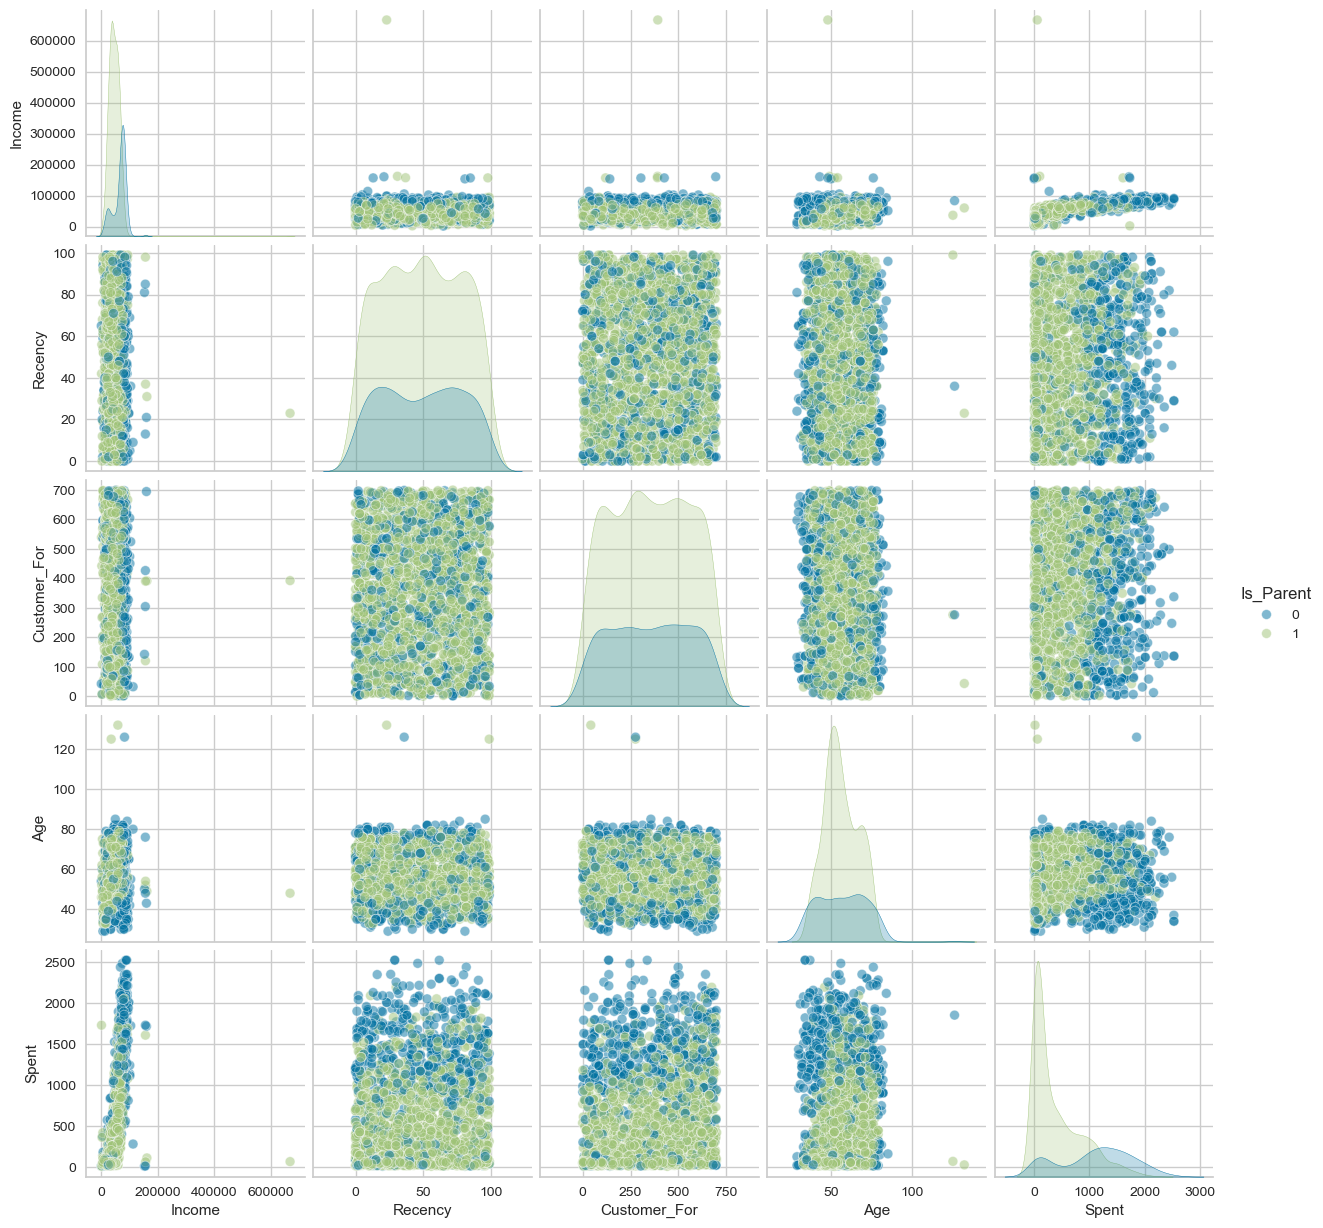

In [38]:
#To plot some selected features 
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent", diag_kind="kde", diag_kws={"color":"black"}, plot_kws={"alpha":0.5, "s":50})
#Taking hue 
plt.show()

In [39]:
#Dropping the outliers by setting a cap on Age and income. 
data = data[(data["Age"]<90)]
data = data[(data["Income"]<300000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

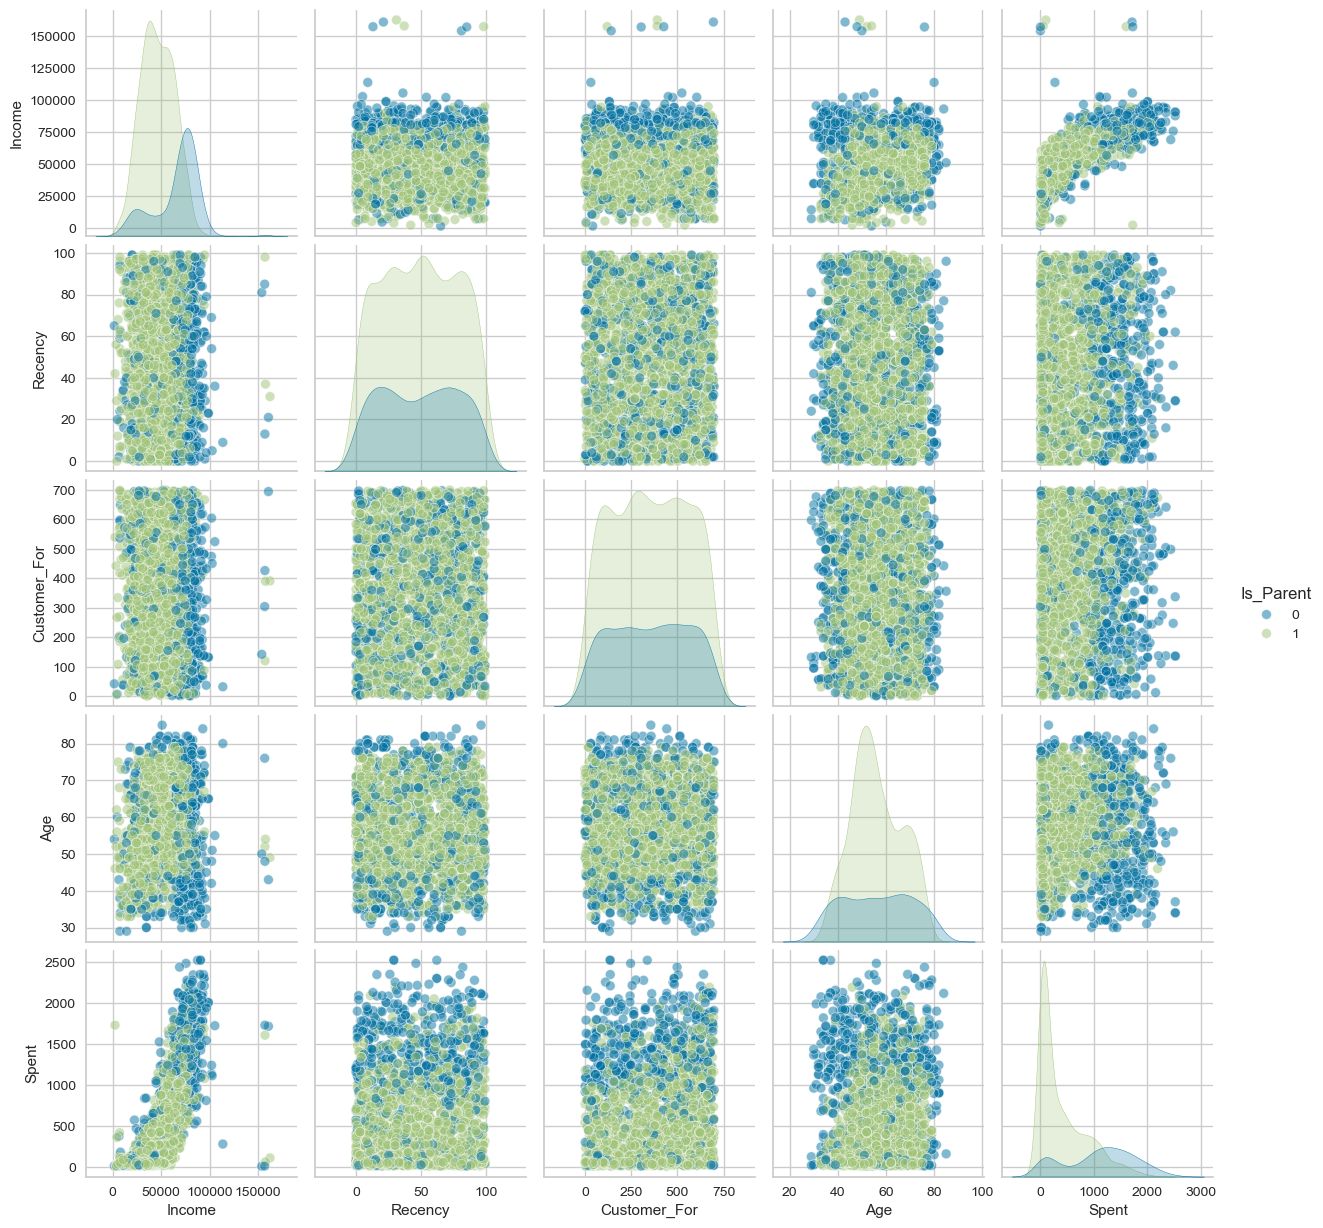

In [40]:
#To plot some selected features 
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent", diag_kind="kde", diag_kws={"color":"black"}, plot_kws={"alpha":0.5, "s":50})
#Taking hue 
plt.show()

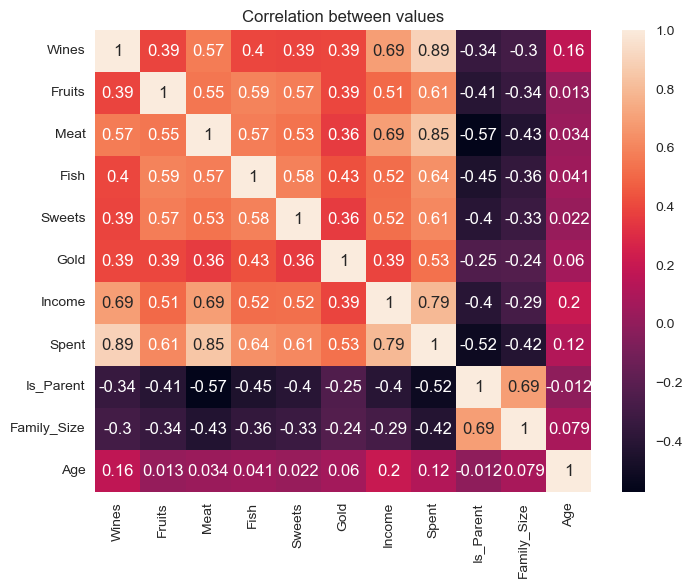

In [41]:
corr_data= data[["Wines","Fruits","Meat","Fish","Sweets","Gold","Income","Spent","Is_Parent","Family_Size", "Age"]]

fig = plt.figure(figsize=(8,6))
plt.title('Correlation between values')
sns.heatmap(corr_data.corr(), annot=True)
plt.show()


In [42]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [43]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [44]:
#Creating a feature to get a sum of accepted promotions 
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

#saveing processed data for streamlit
ds.to_csv('data/processed_data.csv', index=False)

#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [45]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


Education    Income   Kidhome  Teenhome   Recency     Wines    Fruits  \
0  -0.893586  0.287105 -0.822754 -0.929699  0.310353  0.977660  1.552041   
1  -0.893586 -0.260882  1.040021  0.908097 -0.380813 -0.872618 -0.637461   
2  -0.893586  0.913196 -0.822754 -0.929699 -0.795514  0.357935  0.570540   
3  -0.893586 -1.176114  1.040021 -0.929699 -0.795514 -0.872618 -0.561961   
4   0.571657  0.294307  1.040021 -0.929699  1.554453 -0.392257  0.419540   

       Meat      Fish    Sweets  ...  NumStorePurchases  NumWebVisitsMonth  \
0  1.690293  2.453472  1.483713  ...          -0.555814           0.692181   
1 -0.718230 -0.651004 -0.634019  ...          -1.171160          -0.132545   
2 -0.178542  1.339513 -0.147184  ...           1.290224          -0.544908   
3 -0.655787 -0.504911 -0.585335  ...          -0.555814           0.279818   
4 -0.218684  0.152508 -0.001133  ...           0.059532          -0.132545   

   Customer_For       Age     Spent  Living_With  Children  Family_Size  \
0      1.527721  1.018352  1.676245    -1.349603 -1.264598    -1.758359   
1     -1.189011  1.274785 -0.963297    -1.349603  1.404572     0.449070   
2     -0.206048  0.334530  0.280110     0.740959 -1.264598    -0.654644   
3     -1.060584 -1.289547 -0.920135     0.740959  0.069987     0.449070   
4     -0.951915 -1.033114 -0.307562     0.740959  0.069987     0.449070   

   Is_Parent  Total_Promos  
0  -1.581139      -0.43916  
1   0.632456      -0.43916  
2  -1.581139      -0.43916  
3   0.632456      -0.43916  
4   0.632456      -0.43916  

[5 rows x 24 columns]

In [46]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

count          mean       std       min       25%       50%       75%  \
col1  2212.0 -6.424437e-17  2.906465 -5.973690 -2.560571 -0.800546  2.367042   
col2  2212.0  0.000000e+00  1.709774 -4.198236 -1.330596 -0.167657  1.237475   
col3  2212.0 -8.030546e-18  1.231723 -3.623530 -0.860189 -0.052341  0.862426   

           max  
col1  7.870863  
col2  6.165205  
col3  6.747481

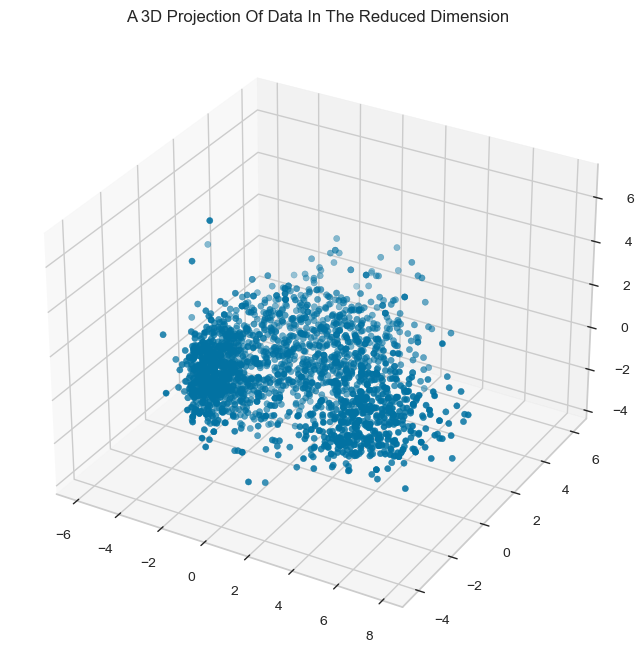

In [47]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

Elbow Method to determine the number of clusters to be formed:


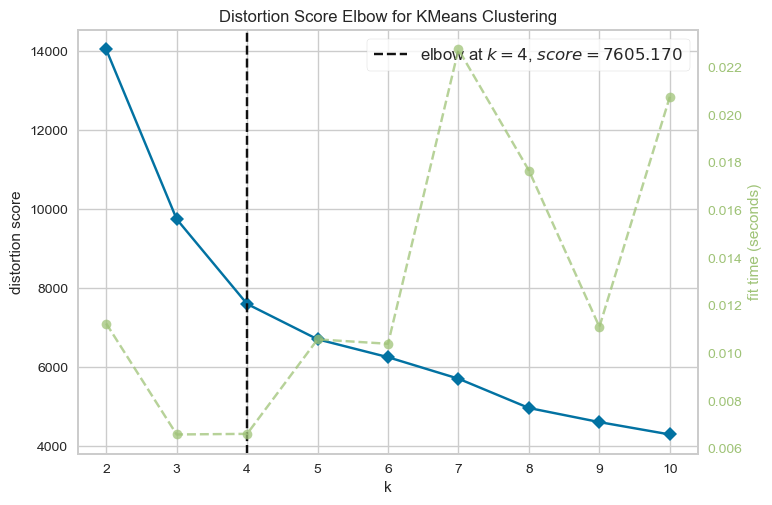

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [49]:
# #Initiating the Agglomerative Clustering model 
# AC = AgglomerativeClustering(n_clusters=4)
# # fit model and predict clusters
# yhat_AC = AC.fit_predict(PCA_ds)
# PCA_ds["Clusters"] = yhat_AC
# #Adding the Clusters feature to the orignal dataframe.
# data["Clusters"]= yhat_AC

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)  # random_state for reproducibility
yhat_kmeans = kmeans.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_kmeans
data["Clusters"] = yhat_kmeans


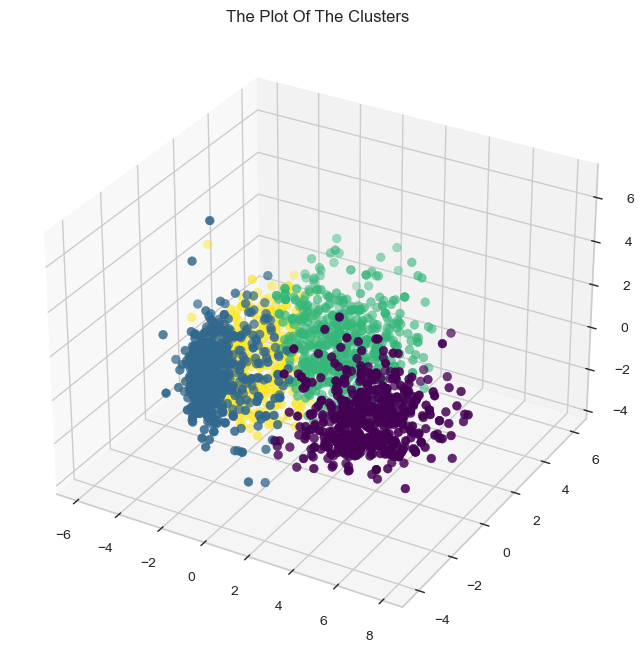

In [50]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = 'viridis')
ax.set_title("The Plot Of The Clusters")
plt.show()

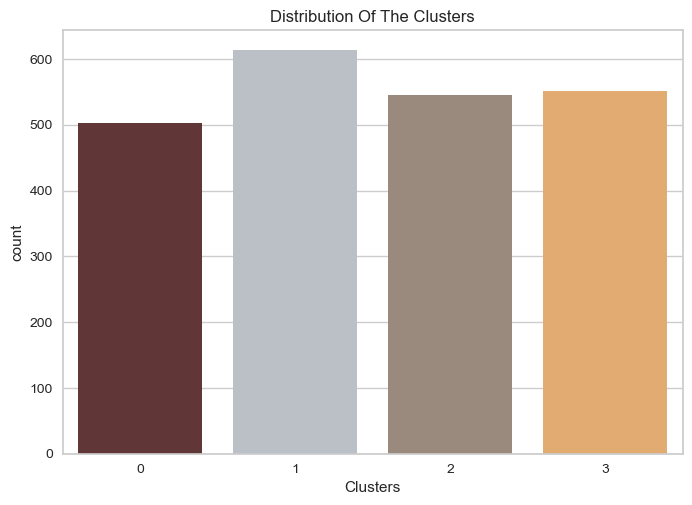

In [51]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

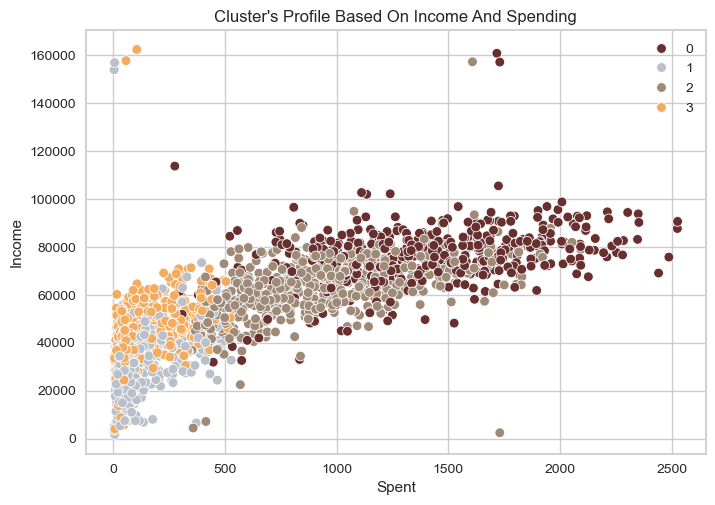

In [52]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

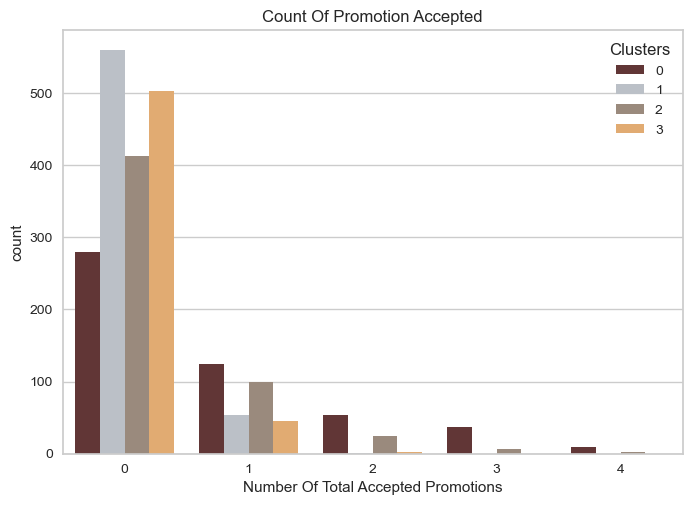

In [53]:
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

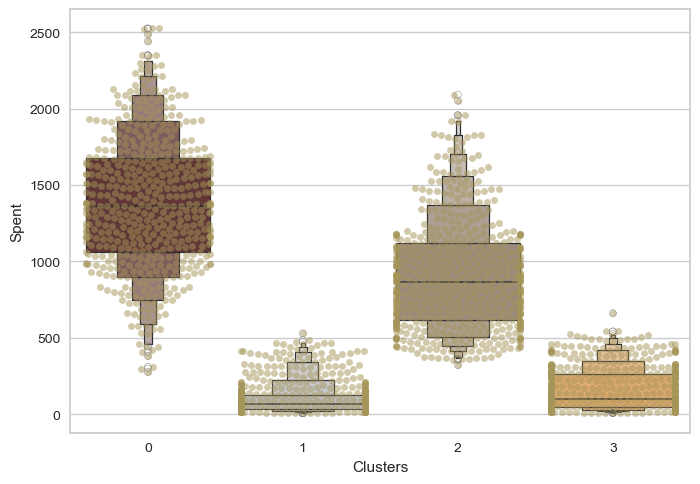

In [54]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#A69559", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()

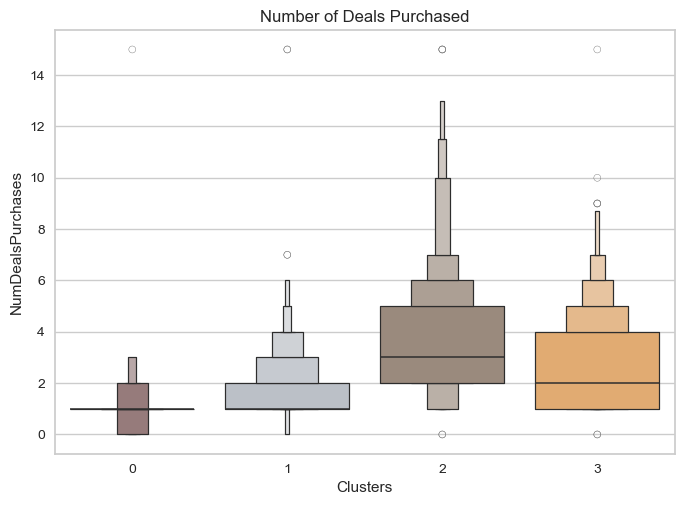

In [55]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

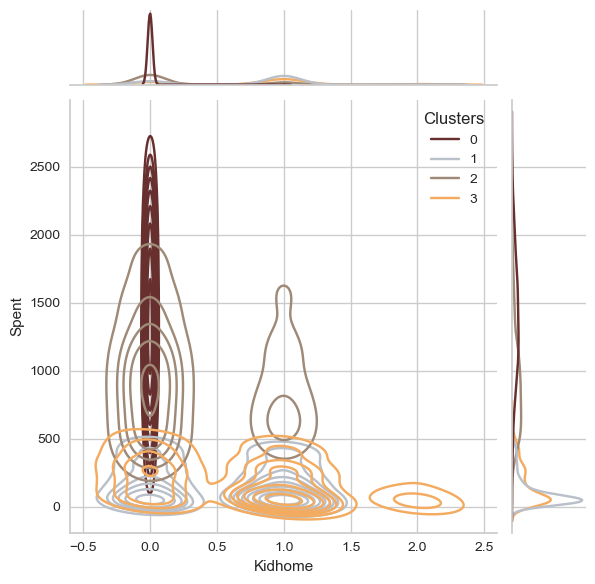

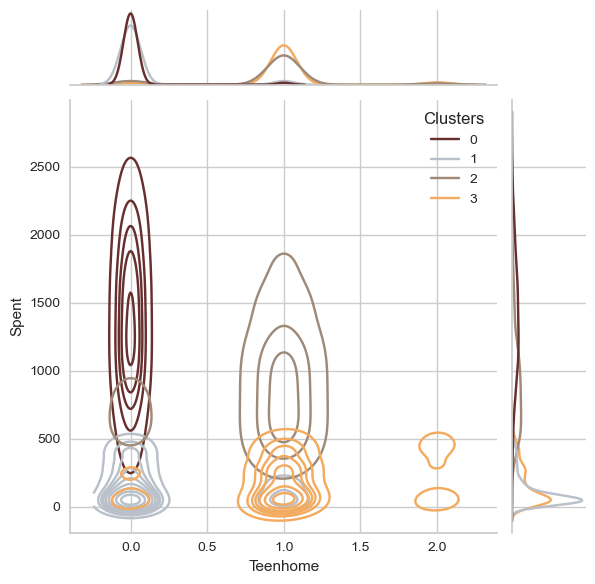

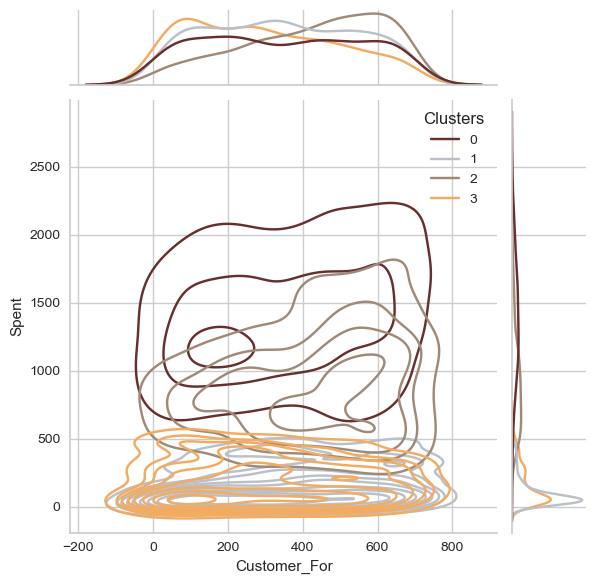

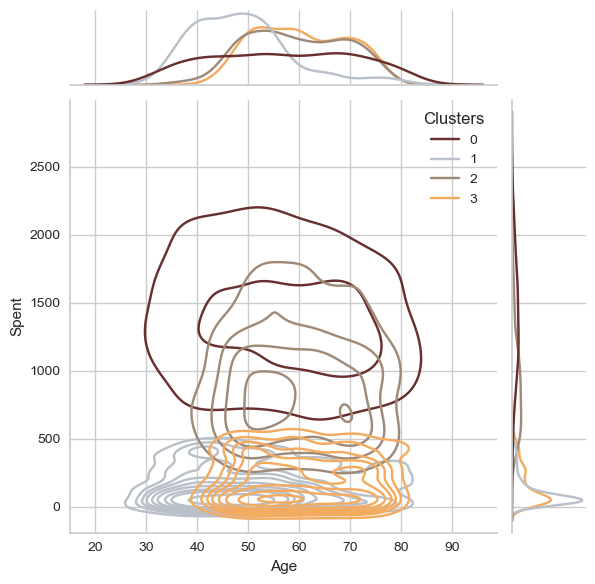

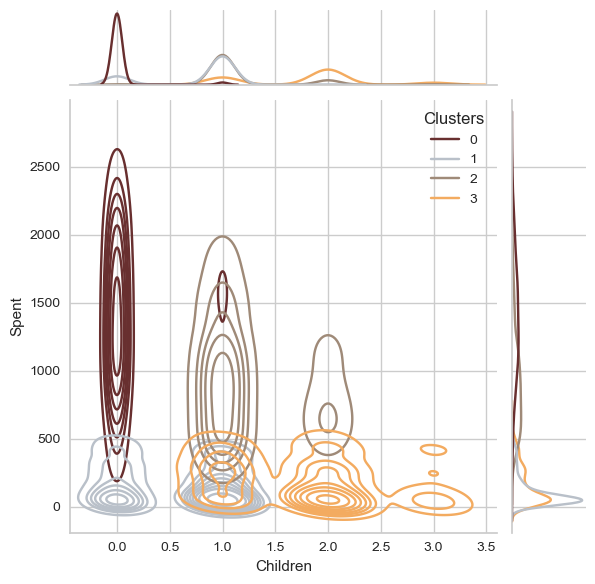

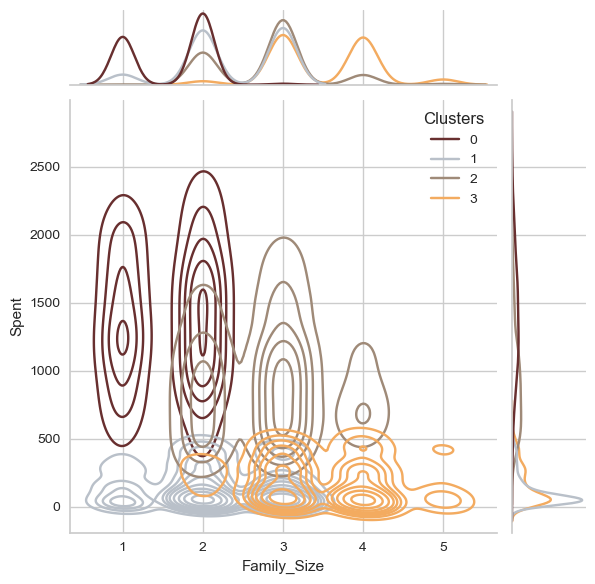

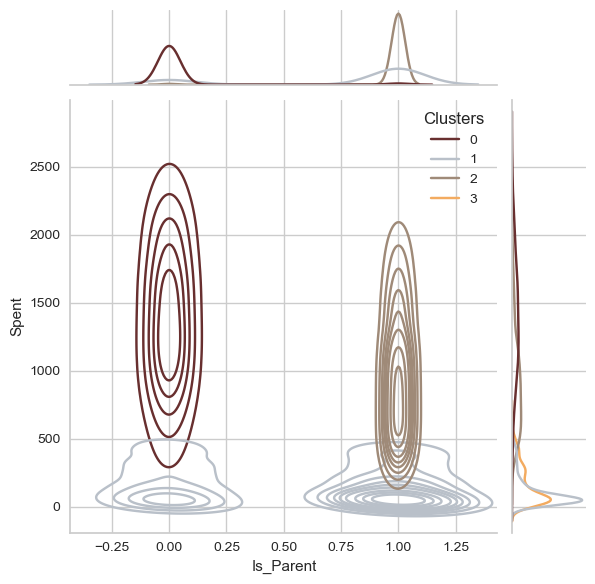

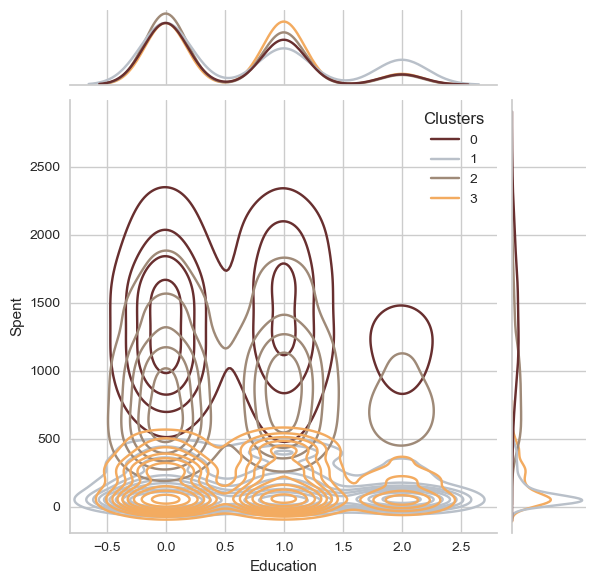

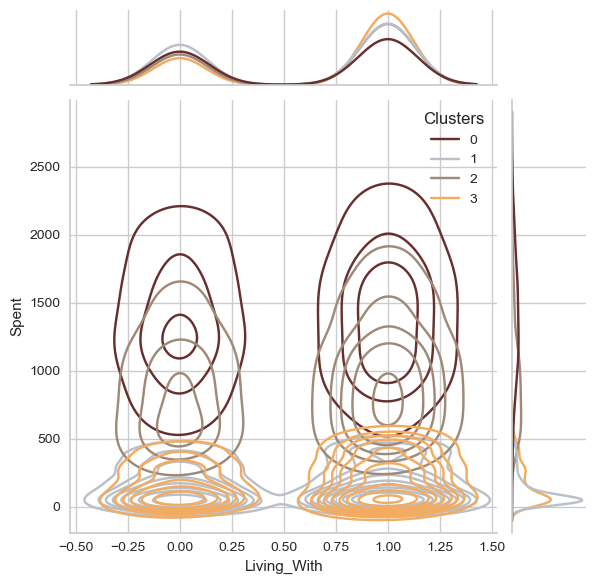

In [56]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()